<a href="https://colab.research.google.com/github/vdorbala/CMSC715-IoT/blob/main/eeg_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip3 install scipy==1.2.1

In [ ]:
!pip3 install cnn_finetune

In [ ]:
!git clone https://github.com/vlawhern/arl-eegmodels

fatal: destination path 'arl-eegmodels' already exists and is not an empty directory.


In [ ]:
%cd arl-eegmodels/
!cp EEGModels.py ../
%cd ../

/content/arl-eegmodels
/content


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time

from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import spline
import os
from os import path

import csv
from cnn_finetune import make_model

from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
from torchsummary import summary
from pandas import Timestamp

# import torch_xla
# import torch_xla.core.xla_model as xm

In [ ]:
!cp EEGModels.py /content/drive/Shareddrives/IoT\ Project
%cd /content/drive/Shareddrives/IoT\ Project/

/content/drive/Shareddrives/IoT Project


In [ ]:
!unzip all.zip -d ./new_all/

KeyboardInterrupt: ignored

In [ ]:
labelfile = open('labelinfo.csv','w+')
labelwriter = csv.writer(labelfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)

In [ ]:
for subdir, dirs, files in os.walk('./new_all'):
    for file in files:
      if "low" in subdir:
        labelwriter.writerow([str(file), "low"])
      elif "high" in subdir:
        labelwriter.writerow([str(file), "high"])
      else:
        labelwriter.writerow([str(file), "normal"])

In [ ]:
labelfile.close()

In [ ]:
class eegdata(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotation_frame = pd.read_csv(csv_file, encoding = 'unicode_escape')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotation_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data_file = os.path.join(self.root_dir, self.annotation_frame.iloc[idx, 1], self.annotation_frame.iloc[idx, 0])
        sc = StandardScaler()
        # data = pd.read_pickle(data_file + ".pkl")
        data = np.load(data_file, allow_pickle=True)

        # data = data.to_numpy()
        # data = data[:1664,:].reshape(104,64)
        data = data[:1664,20:24]
        data = sc.fit_transform(data)
        
        glucose_level = self.annotation_frame.iloc[idx, 1:]
        if glucose_level is 'high':
          glucose_level = [1,0,0]
        elif glucose_level is 'normal':
          glucose_level = [0,1,0]
        else:
          glucose_level = [0,0,1]
        glucose_level = np.array([glucose_level])
        glucose_level = glucose_level.astype('long').reshape(1, 3)
        glucose_level = torch.LongTensor(glucose_level)
        # glucose_level = glucose_level.astype('float').reshape(-1, 3)
        sample = {'data': data, 'glucose': glucose_level}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
!ls

 all.zip	      labeled				  models
 arl-eegmodels	      labelinfo.csv			  new_all
 EEGlab.h5	     'Loss Graph 2021-12-19 204617.png'   __pycache__
 EEGModels.py	     'Loss Graph 2021-12-19 205823.png'   resnet50.csv
 eeg_model_vals.csv  'Loss Graph 2021-12-19 212259.png'


In [ ]:
def show_landmarks(data, glucose):
    """Show image with landmarks"""
    plt.imshow(data)
    plt.scatter(glucose[:, 0], glucose[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
glucose_dataset = eegdata(csv_file='/content/drive/Shareddrives/IoT Project/labelinfo.csv',
                                    root_dir='/content/drive/Shareddrives/IoT Project/new_all/')

print(np.shape(glucose_dataset[0]['data']))
print(glucose_dataset[0]['data'])
# print(np.shape(glucose_dataset))

(1664, 4)
[[ 0.39389359  0.67844869 -0.6301981  -0.38628329]
 [ 0.39389359  0.67844869 -0.6301981  -0.38628329]
 [ 0.39389359  0.67844869 -0.6301981  -0.38628329]
 ...
 [ 0.20556782 -1.0049936  -2.30114337 -2.32456914]
 [ 0.20556782 -1.0049936  -2.30114337 -2.32456914]
 [ 0.20556782 -1.0049936  -2.30114337 -2.32456914]]


In [ ]:
fig = plt.figure()

for i in range(len(glucose_dataset)):
    sample = glucose_dataset[i]

    print(i, sample['data'].shape, sample['glucose'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break


# The Model

We utilize EEGNet to train our model.

In [ ]:
# class TinyConv(nn.Module):
#     """Tiny convolutional neural network.
#     Uses nn.Sequential to improve organization."""
#     def __init__(self):
#         super(TinyConv, self).__init__()
#         self.conv = nn.Sequential(
#                             nn.Conv2d(1, 8, kernel_size = (3,3), stride=(3,3), padding=0),
#                             nn.ReLU(inplace=True),
                    
#                             nn.Conv2d(8, 16, kernel_size = (3,3), stride=(3,3), padding=0),
#                             nn.ReLU(inplace=True))
#         self.fc = nn.Linear(in_features=16*3*3,out_features=3)
    
#     def forward(self, x):
#         x = self.conv(x)
#         x = torch.flatten(x,start_dim=1,end_dim=-1)
#         x = self.fc(x)
#         out = {'out':x}
#         return out

In [ ]:
beginning = time.time()

use_gpu=0
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_gpu=1 
    print ("CUDA Available")

epochs = 5

batch_size = 64
batch_size_test = 64
epochs_num = epochs

print ("Batch size is {0}".format(batch_size))
print ("Batch size test is {0}".format(batch_size_test))
print ("Epoch size is {0}".format(epochs_num))
PATH = './models/Convnet_epoch1'

CUDA Available
Batch size is 64
Batch size test is 64
Epoch size is 5


In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 1664
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 4), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(4*2*104, 3)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        # print(x.size())
        # FC Layer
        x = x.reshape(-1, 4*2*104)
        x = torch.relu(self.fc1(x))
        return x


model = EEGNet().cuda(0)
summary(model, (1, 1664, 4))
print (model.forward(Variable(torch.Tensor(np.random.rand(1, 1, 1664, 4)).cuda(0))))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 1664, 1]              80
       BatchNorm2d-2          [-1, 16, 1664, 1]              32
         ZeroPad2d-3          [-1, 1, 17, 1697]               0
            Conv2d-4          [-1, 4, 16, 1666]             260
       BatchNorm2d-5          [-1, 4, 16, 1666]               8
         MaxPool2d-6            [-1, 4, 4, 417]               0
         ZeroPad2d-7           [-1, 4, 11, 420]               0
            Conv2d-8            [-1, 4, 4, 417]             516
       BatchNorm2d-9            [-1, 4, 4, 417]               8
        MaxPool2d-10            [-1, 4, 2, 104]               0
           Linear-11                    [-1, 3]           2,499
Total params: 3,403
Trainable params: 3,403
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/back

In [ ]:
model_ft = model.to(device)

if use_gpu == 1:
    model_ft = nn.DataParallel(model_ft).cuda()

# if path.exists(PATH):
    # model_ft.load_state_dict(torch.load(PATH))

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()

optimizer = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.999)
# optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(glucose_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(glucose_dataset, batch_size=batch_size, num_workers=2,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(glucose_dataset, batch_size=batch_size_test, num_workers=2,
                                                sampler=valid_sampler)


In [ ]:
print("Glucose dataset size is {}. \nTrain set size is {}. \nValidation set size is {}.".format(len(glucose_dataset),len(train_loader), len(validation_loader)))

Glucose dataset size is 37077. 
Train set size is 464. 
Validation set size is 116.


In [ ]:
trainlossarr = []
testlossarr = []

In [ ]:
def train(epoch):
    global rdeftrain, trainlossarr
    since = time.time()
    total_loss = 0
    total_size = 0
    traintargetarr = []
    trainoutputarr = []
    model_ft.train()

    for batch_idx, values in enumerate(train_loader):
        
        data, target = values['data'], values['glucose']

        # print(target)
        data = data.unsqueeze(1).float()
        # data = data.view(-1, 4*2*6*batch_size)
        target = target.view(-1, 3).float()

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model_ft(data)
        
        traintargetarr.append(target.tolist())
        trainoutputarr.append(output.tolist())

        # output = torch.transpose(output, 0, 1)
        # print(data.size(), target.size(), output.size())

        # print(output, target)

        loss = criterion(output, target.squeeze())

        total_loss += loss.item()

        total_size += 1

        loss.backward()
        
        optimizer.step()
        # print((total_loss/total_size)*100)

    # tta = np.array(traintargetarr)
    # tta = [val for sublist in traintargetarr for val in sublist]
    # tta = np.array(tta)
    # toa = np.array(trainoutputarr)
    # toa = [val for sublist in trainoutputarr for val in sublist]
    # toa = np.array(toa)

    trainlossarr.append((total_loss/total_size))

In [ ]:
def test():
    global tta,toa,rdeftest,testlossarr
    # model_ft.load_state_dict(torch.load(PATH))
    model_ft.eval()
    test_loss = 0
    total_loss = 0
    total_size = 0

    testtargetarr = []
    testoutputarr = []

    with torch.no_grad():
        for batch_idx, values in enumerate(validation_loader):

            data, target = values['data'], values['glucose']
            
            data = data.unsqueeze(1).float()
            target = target.view(-1,3).float()

            data, target = data.to(device), target.to(device)

            output = model_ft(data)

            # print(data.size(), target.size(), output.size())

            # print(output, target)

            loss = criterion(output, target.squeeze())

            total_loss += loss.item()

            total_size += 1
        
            testtargetarr.append(target.tolist())
            testoutputarr.append(output.tolist())

            print ("Loss is {}".format(loss*100))

    # tta = np.array(testtargetarr)
    # tta = [val for sublist in testtargetarr for val in sublist]
    # tta = np.array(tta)
    # toa = np.array(testoutputarr)
    # toa = [val for sublist in testoutputarr for val in sublist]
    # toa = np.array(toa) 
    testlossarr.append(total_loss/total_size)

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()
    print ("\nEpoch number is {}.".format(epoch))
    print("Current train loss is {}. \nCurrent test loss is {}.".format((sum(trainlossarr)/epoch),sum(testlossarr)/epoch))

    if epoch % 10 == 0:
        print("Loss at epoch {} is {}%".format(epoch,100*(sum(testlossarr)/epoch)))

Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0
Loss is -0.0

Process complete in 101m 39s
(5,) (5,)


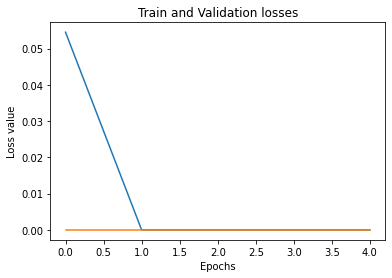

In [ ]:
time_elapsed = time.time() - beginning
print('Process complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

trainlossarr = np.array(trainlossarr)
testlossarr = np.array(testlossarr)

print(np.shape(trainlossarr), np.shape(testlossarr))


file = open("eeg_model_vals.csv","w+")

file.write("Train values are \n")

for i in range(len(trainlossarr)):
    file.write("{},".format(trainlossarr[i]))

file.write("\n Test values are \n")

for i in range(len(testlossarr)):
    file.write("{},".format(testlossarr[i]))

file.close()

t = np.arange(0,epochs_num,1)

plt.plot(t,trainlossarr,t,testlossarr)
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.title("Train and Validation losses")
plt.show()

In [ ]:
# save general model
!mkdir models
torch.save(model.state_dict(), "./models/raw_conv_{}".format(time.strftime("%Y-%m-%d %H%M%S")))

mkdir: cannot create directory ‘models’: File exists


In [ ]:
import datetime

In [ ]:
plt.savefig("Loss Graph "+ time.strftime("%Y-%m-%d %H%M%S") + ".png")

<Figure size 432x288 with 0 Axes>

In [ ]:
pred = model_ft(data)